# UV Driver Behavior Modeling Using HMM

## Import Dependencies

In [1]:
import re
import statistics
import numpy as np
import matplotlib.pyplot as plt
import itertools
import operator
from hmmlearn import hmm
from datetime import datetime
from pandas import DataFrame
from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
import pandas as pd
import seaborn as sns
np.random.seed(1)

## Exploratory Data Analysis

### Read CSV files

In [2]:
# Peak Hours CSV
peak_df = pd.read_csv('peak.csv')
peak_df["Timestamp"] = pd.to_datetime(peak_df["Timestamp"], format="%H:%M:%S")
peak_df["Observed State"] = peak_df["Observed State"].str.capitalize()

# Non-Peak Hours CSV
non_peak_df = pd.read_csv('non_peak.csv')
non_peak_df["Timestamp"] = pd.to_datetime(non_peak_df["Timestamp"], format="%H:%M:%S")
non_peak_df["Observed State"] = non_peak_df["Observed State"].str.capitalize()

### Frequency of Hidden States

In [3]:
peak_hidden_state_counts = peak_df["Hidden State"].value_counts()
print("Hidden State Counts For Peak Hour Trips:\n", peak_hidden_state_counts)

Hidden State Counts For Peak Hour Trips:
 Hidden State
Vehicle      612
Passenger    342
Stoplight     99
Name: count, dtype: int64


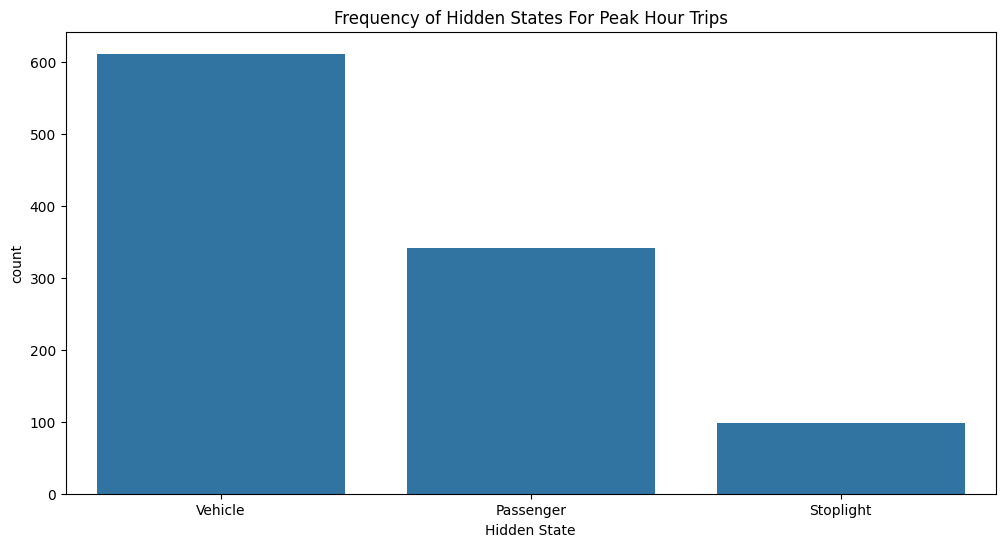

In [4]:
plt.figure(figsize=(12, 6))
sns.countplot(data=peak_df, x="Hidden State", order=peak_df["Hidden State"].value_counts().index)
plt.title("Frequency of Hidden States For Peak Hour Trips")
plt.show()

In [5]:
non_peak_hidden_state_counts = non_peak_df["Hidden State"].value_counts()
print("Hidden State Counts For Non-Peak Hour Trips:\n", non_peak_hidden_state_counts)

Hidden State Counts For Non-Peak Hour Trips:
 Hidden State
Vehicle      627
Passenger    185
Stoplight     91
Name: count, dtype: int64


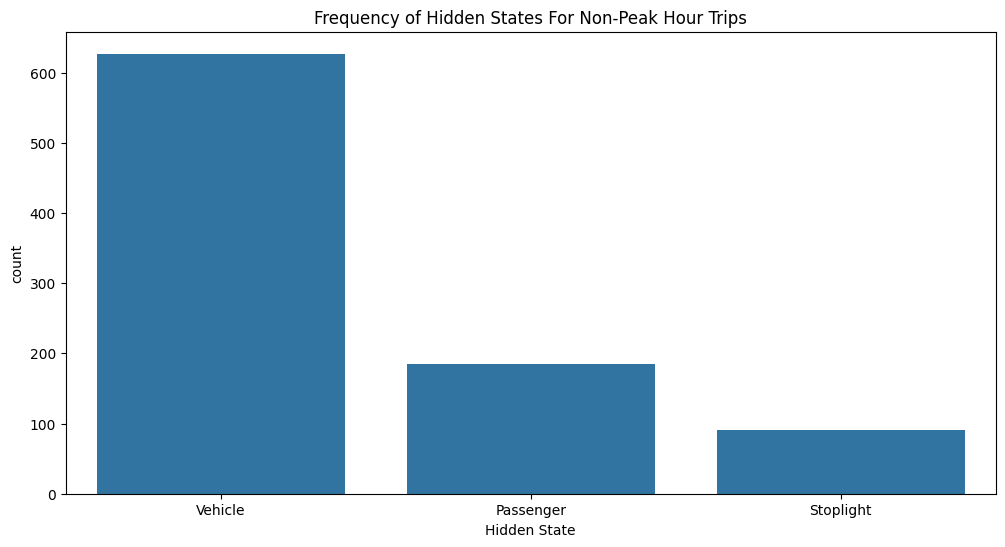

In [6]:
plt.figure(figsize=(12, 6))
sns.countplot(data=non_peak_df, x="Hidden State", order=non_peak_df["Hidden State"].value_counts().index)
plt.title("Frequency of Hidden States For Non-Peak Hour Trips")
plt.show()

### Distribution of Hidden States for Each Trips for Both Types of Traffic

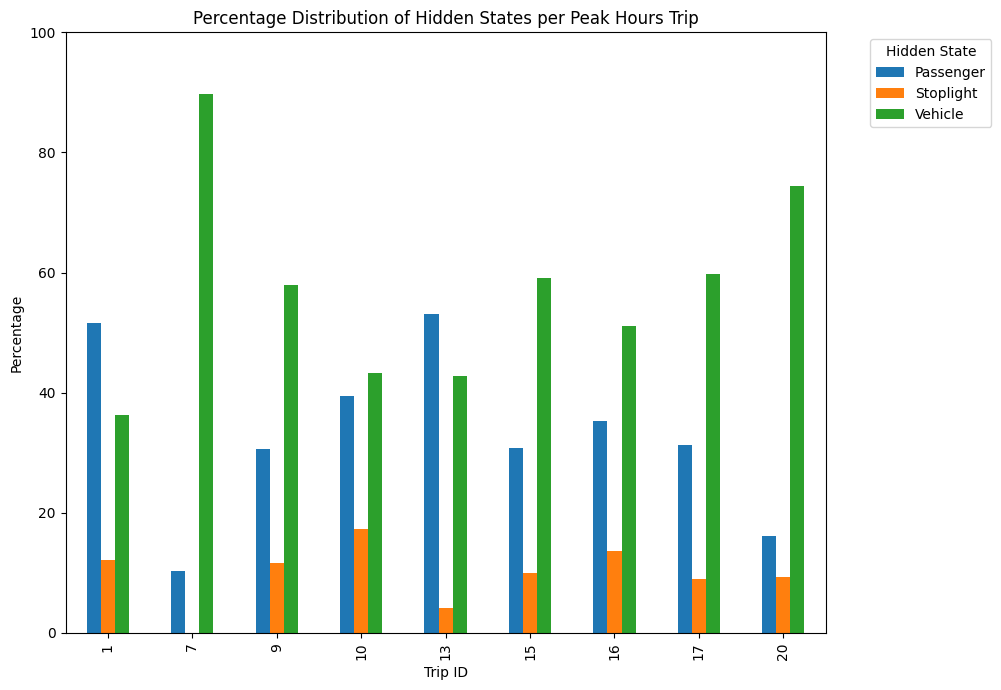

In [7]:
trip_counts = peak_df.groupby(['Trip ID', 'Hidden State']).size().unstack(fill_value=0)

trip_percentages = trip_counts.div(trip_counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 7))
trip_percentages.plot(kind='bar', stacked=False, ax=ax)

ax.legend(title='Hidden State', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))

plt.xlabel('Trip ID')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Hidden States per Peak Hours Trip')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

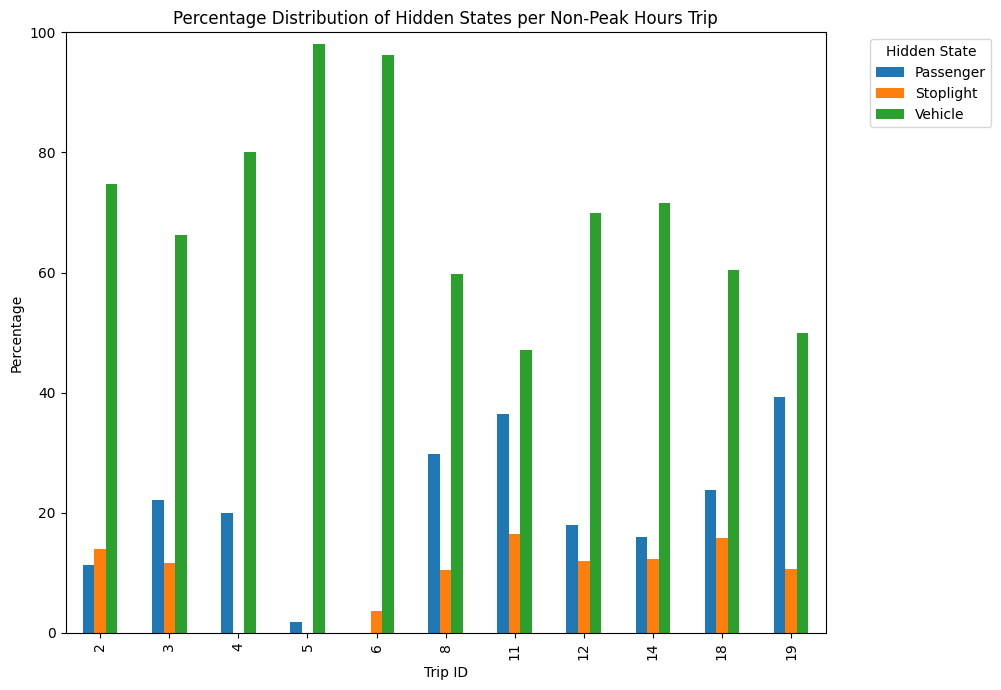

In [8]:
trip_counts = non_peak_df.groupby(['Trip ID', 'Hidden State']).size().unstack(fill_value=0)

trip_percentages = trip_counts.div(trip_counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 7))
trip_percentages.plot(kind='bar', stacked=False, ax=ax)

ax.legend(title='Hidden State', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))

plt.xlabel('Trip ID')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Hidden States per Non-Peak Hours Trip')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

### Frequency of Observed States

In [9]:
peak_state_counts = peak_df["Observed State"].value_counts()
print("Observed State Counts For Peak Hour Trips:\n", peak_state_counts)

Observed State Counts For Peak Hour Trips:
 Observed State
Change lane right    310
Change lane left     281
Go                   176
Stop                 172
Load                  59
Unload                55
Name: count, dtype: int64


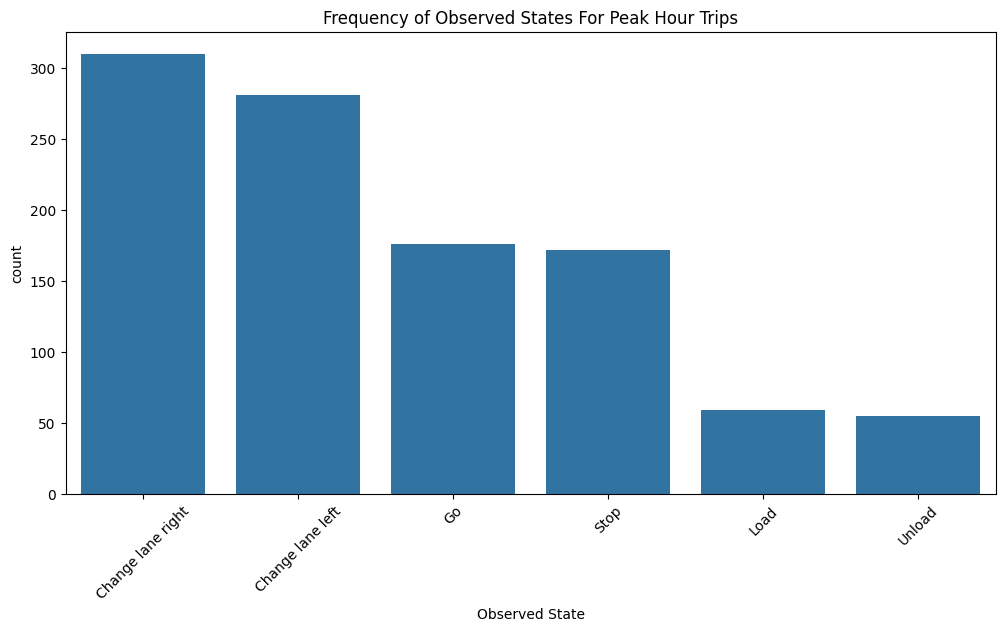

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(data=peak_df, x="Observed State", order=peak_df["Observed State"].value_counts().index)
plt.title("Frequency of Observed States For Peak Hour Trips")
plt.xticks(rotation=45)
plt.show()

In [11]:
non_peak_state_counts = non_peak_df["Observed State"].value_counts()
print("Observed State Counts For Non-Peak Hour Trips:\n", non_peak_state_counts)

Observed State Counts For Non-Peak Hour Trips:
 Observed State
Change lane right    327
Change lane left     308
Stop                 104
Go                   103
Unload                39
Load                  22
Name: count, dtype: int64


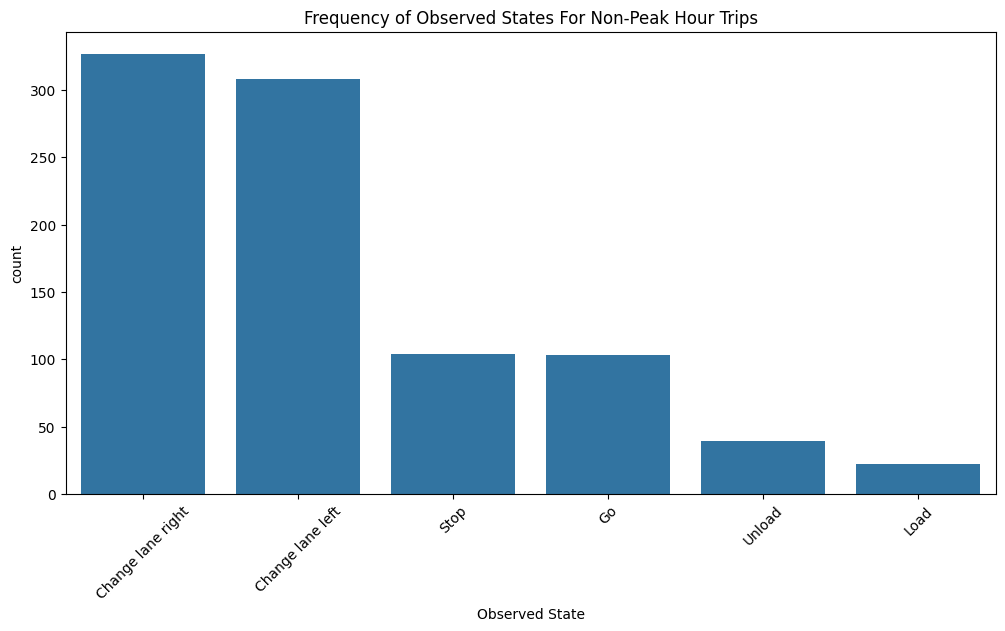

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=non_peak_df, x="Observed State", order=non_peak_df["Observed State"].value_counts().index)
plt.title("Frequency of Observed States For Non-Peak Hour Trips")
plt.xticks(rotation=45)
plt.show()

### Hidden State Transition Matrix

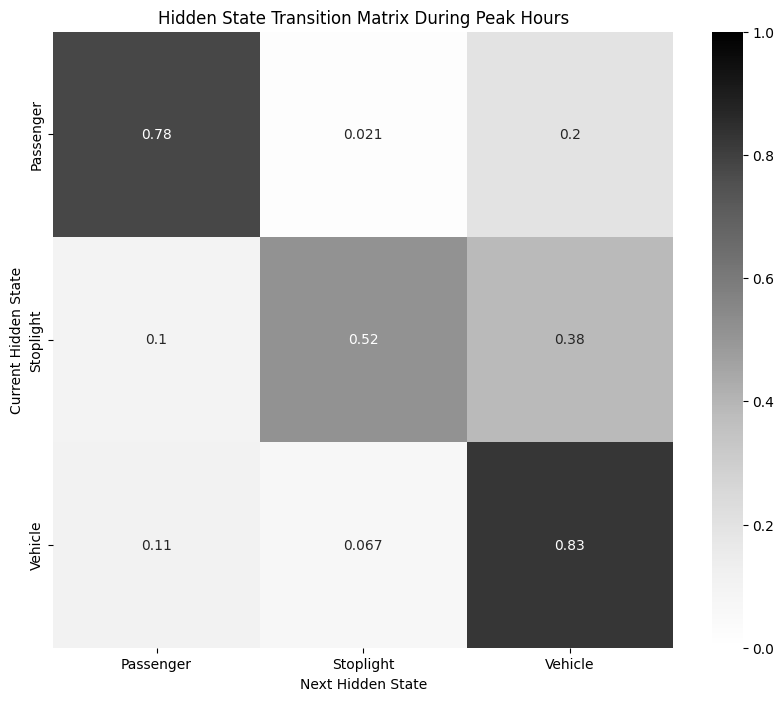

In [13]:
peak_df["Next Hidden State"] = peak_df["Hidden State"].shift(-1)

peak_df = peak_df.dropna()

hidden_state_transition_matrix = pd.crosstab(peak_df["Hidden State"], peak_df["Next Hidden State"], normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(hidden_state_transition_matrix, annot=True, cmap="Greys", cbar=True, vmin=0, vmax=1)
plt.title("Hidden State Transition Matrix During Peak Hours")
plt.xlabel("Next Hidden State")
plt.ylabel("Current Hidden State")
plt.show()

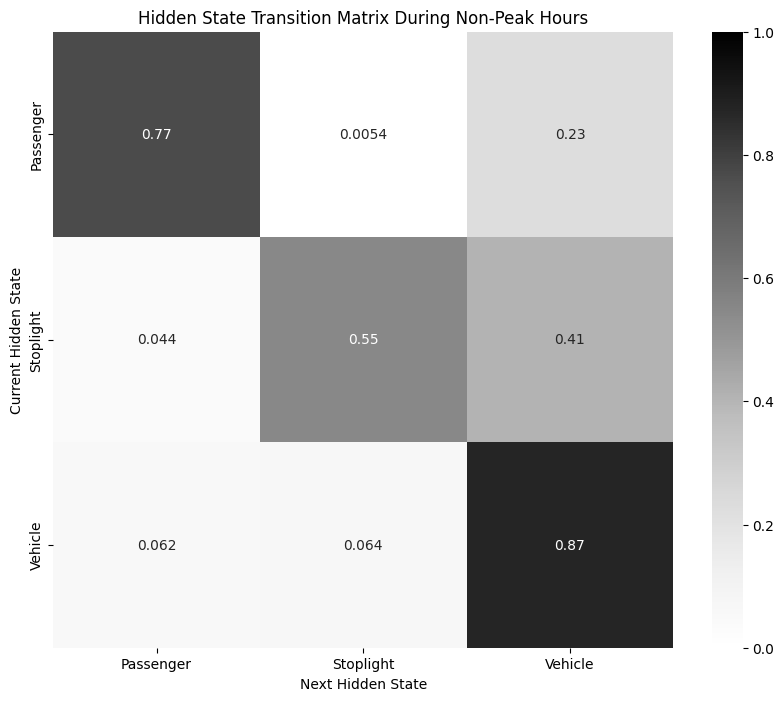

In [14]:
non_peak_df["Next Hidden State"] = non_peak_df["Hidden State"].shift(-1)

non_peak_df = non_peak_df.dropna()

hidden_state_transition_matrix = pd.crosstab(non_peak_df["Hidden State"], non_peak_df["Next Hidden State"], normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(hidden_state_transition_matrix, annot=True, cmap="Greys", cbar=True, vmin=0, vmax=1)
plt.title("Hidden State Transition Matrix During Non-Peak Hours")
plt.xlabel("Next Hidden State")
plt.ylabel("Current Hidden State")
plt.show()

### Observed State Transition Matrix

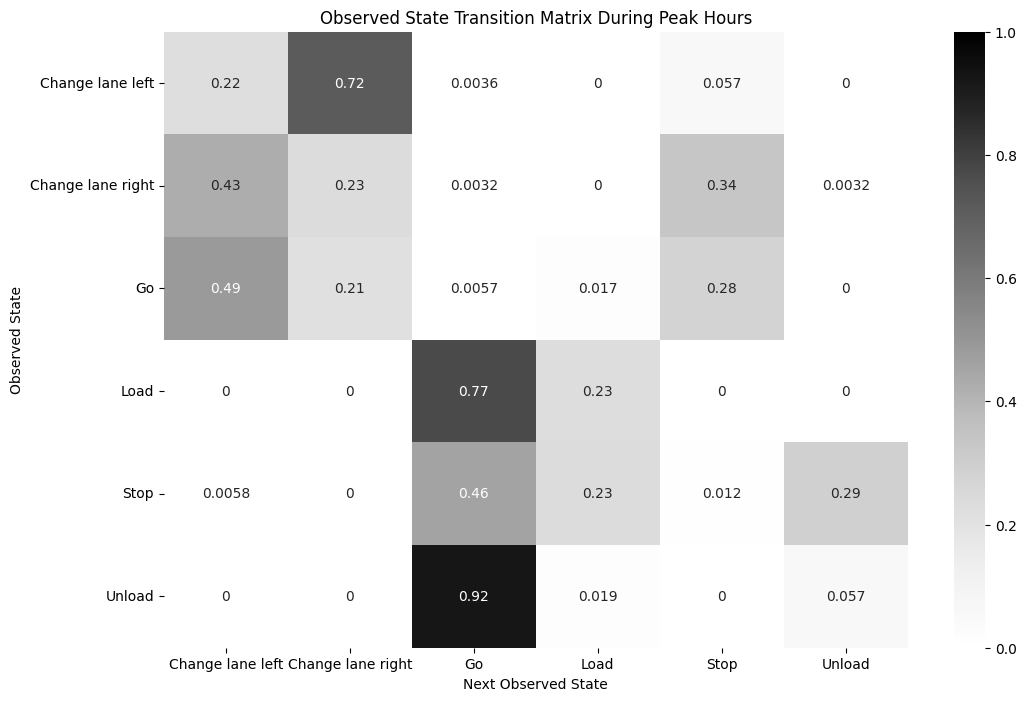

In [15]:
peak_df["Next Observed State"] = peak_df["Observed State"].shift(-1)

peak_df = peak_df.dropna()

peak_df_transition_matrix = pd.crosstab(peak_df["Observed State"], peak_df["Next Observed State"], normalize='index')

plt.figure(figsize=(12, 8))
sns.heatmap(peak_df_transition_matrix, annot=True, cmap="Greys", cbar=True, vmin=0, vmax=1)
plt.title("Observed State Transition Matrix During Peak Hours")
plt.show()

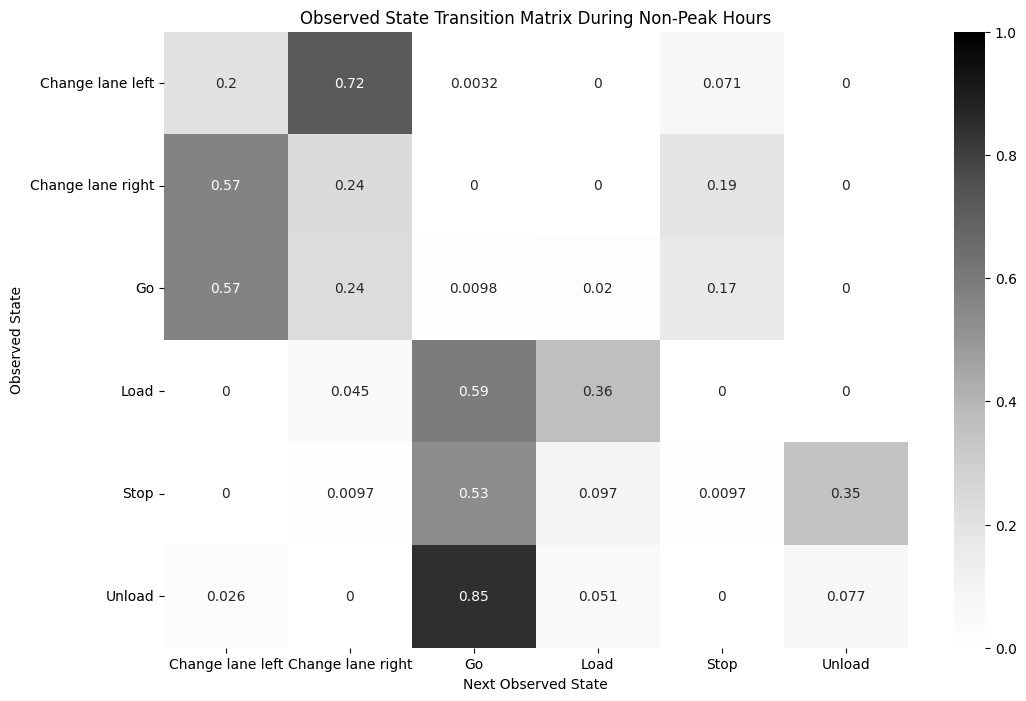

In [16]:
non_peak_df["Next Observed State"] = non_peak_df["Observed State"].shift(-1)

non_peak_df = non_peak_df.dropna()

non_peak_df_transition_matrix = pd.crosstab(non_peak_df["Observed State"], non_peak_df["Next Observed State"], normalize='index')

plt.figure(figsize=(12, 8))
sns.heatmap(non_peak_df_transition_matrix, annot=True, cmap="Greys", cbar=True, vmin=0, vmax=1)
plt.title("Observed State Transition Matrix During Non-Peak Hours")
plt.show()

### Hidden State to Observable State Transition Matrix

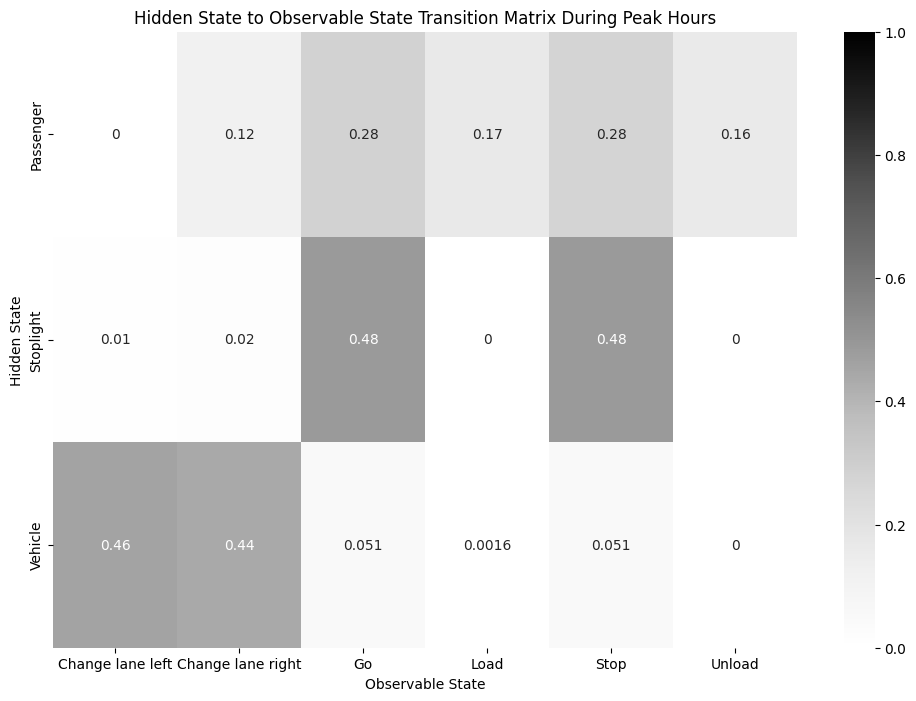

In [17]:
peak_df_hidden_to_observed_matrix = pd.crosstab(peak_df["Hidden State"], peak_df["Observed State"], normalize='index')

plt.figure(figsize=(12, 8))
sns.heatmap(peak_df_hidden_to_observed_matrix, annot=True, cmap="Greys", cbar=True, vmin=0, vmax=1)
plt.title("Hidden State to Observable State Transition Matrix During Peak Hours")
plt.xlabel("Observable State")
plt.ylabel("Hidden State")
plt.show()

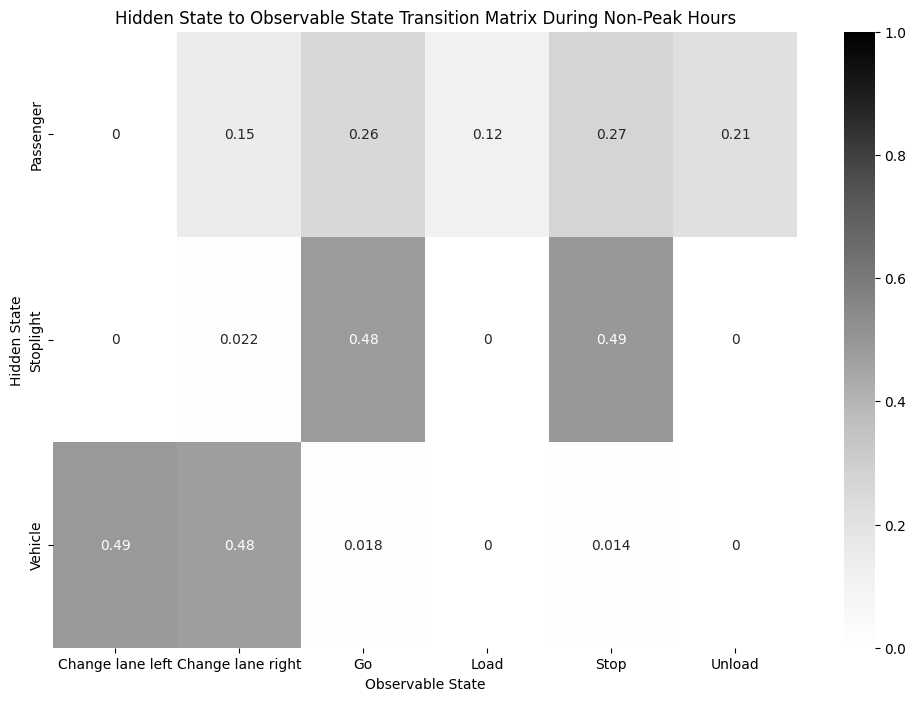

In [18]:
non_peak_df_hidden_to_observed_matrix = pd.crosstab(non_peak_df["Hidden State"], non_peak_df["Observed State"], normalize='index')

plt.figure(figsize=(12, 8))
sns.heatmap(non_peak_df_hidden_to_observed_matrix, annot=True, cmap="Greys", cbar=True, vmin=0, vmax=1)
plt.title("Hidden State to Observable State Transition Matrix During Non-Peak Hours")
plt.xlabel("Observable State")
plt.ylabel("Hidden State")
plt.show()

## Training the Hidden Markov Model

### Create List of Possible Hidden States

In [19]:
states = ['Passenger', 'Vehicle', 'Stoplight']
n_states = len(states)

### Create a List of Possible Observable States 

In [20]:
# Oberservable states
observations = ['ChangeLaneLeft', 'ChangeLaneRight', 'Stop', 'Go', 'Load', 'Unload']

### Load Collected Data

In [21]:
# Load event file
my_file = open('data.csv', 'r', encoding='utf-8-sig')
# Get everything from file
observed_states = [] # Passenger, Vehicle, Stoplight
observed_state_changes = [] # P (Passenger), V (Vehicle), S (Stoplight), N = No Change, this takes note of the changes
observed_events = [] # Order of annotated events

for line in my_file:
    l = [i.strip() for i in line.split(',')]
    observed_states.append(l[0]) # i.e. ['Passenger', 'P', 'Stop', datetime], l[0] = states, l[1] = state (if changed/observed_no change), 
    observed_state_changes.append(l[1]) # l[2] = event
    observed_events.append(l[2])

### Calculate Start Probability

In [22]:
# sp = start probability
total_count = len(observed_states)
sp_passenger = observed_states.count('Passenger') / total_count
sp_vehicle = observed_states.count('Vehicle') / total_count
sp_stoplight = observed_states.count('Stoplight') / total_count

print('Start probabilities')
print(sp_passenger, sp_vehicle, sp_stoplight)
start_probability = np.array([sp_passenger, sp_vehicle, sp_stoplight])

Start probabilities
0.2563380281690141 0.6431924882629108 0.10046948356807511


### Convert State Changes to Transition States 

In [23]:
# Get the transition states
temp = ''
transition_state = []
for cur_state in observed_state_changes:
    if temp == '':
        temp = cur_state
    else:
        if cur_state != 'N':
            word = temp+cur_state
            transition_state.append(word)
            temp = cur_state

### Calculate Transition Probabilities

In [24]:
# tp = transition probability 
# p = passenger, v = vehicle, s = stoplight
# pp = passenger x passenger, pv = passenger x vehicle, ps = passenger x stoplight
total_transition = len(transition_state)
total_p = transition_state.count('PP') + transition_state.count('PV') + transition_state.count('PS')
total_v = transition_state.count('VP') + transition_state.count('VV') + transition_state.count('VS')
total_s = transition_state.count('SP') + transition_state.count('SV') + transition_state.count('SS')

# P transition probabilities
tp_pp = transition_state.count('PP') / total_p
tp_pv = transition_state.count('PV') / total_p
tp_ps = transition_state.count('PS') / total_p

# V transition probabilities
tp_vp = transition_state.count('VP') / total_v
tp_vv = transition_state.count('VV') / total_v
tp_vs = transition_state.count('VS') / total_v

# S transition probabilities
tp_sp = transition_state.count('SP') / total_s
tp_sv = transition_state.count('SV') / total_s
tp_ss = transition_state.count('SS') / total_s

transition_probability = np.array([[tp_pp, tp_pv, tp_ps],
                                   [tp_vp, tp_vv, tp_vs],
                                   [tp_sp, tp_sv, tp_ss]])

In [25]:
print('------------------------')
print('Transition probabilities')
print(tp_pp, tp_pv, tp_ps)
print(tp_vp, tp_vv, tp_vs)
print(tp_sp, tp_sv, tp_ss)

------------------------
Transition probabilities
0.7761467889908257 0.20917431192660552 0.014678899082568808
0.07883211678832117 0.8532846715328467 0.06788321167883211
0.06542056074766354 0.40654205607476634 0.5280373831775701


### Get Emissions 

In [26]:
temp_events_num = []

for event in observed_events:
    if event == 'ChangeLaneLeft':
        temp_events_num.append(0)
    elif event == 'ChangeLaneRight':
        temp_events_num.append(1)
    elif event == 'Stop':
        temp_events_num.append(2)
    elif event == 'Go':
        temp_events_num.append(3)
    elif event == 'Load':
        temp_events_num.append(4)
    elif event == 'Unload':
        temp_events_num.append(5)

print(len(observed_states))
print(len(temp_events_num))
emission = []
for i in range(0, total_count):
    emission.append(observed_states[i]+str(temp_events_num[i]))   

events_num = np.array([temp_events_num]).reshape(-1,1)

2130
2130


### Calculate Emission Probabilities

In [27]:
# P to event X emission probabilities
total_ep = emission.count('Passenger0') + emission.count('Passenger1') + emission.count('Passenger2') + emission.count('Passenger3') + emission.count('Passenger4') + emission.count('Passenger5')
ep_p0 = emission.count('Passenger0') / total_ep
ep_p1 = emission.count('Passenger1') / total_ep
ep_p2 = emission.count('Passenger2') / total_ep
ep_p3 = emission.count('Passenger3') / total_ep
ep_p4 = emission.count('Passenger4') / total_ep
ep_p5 = emission.count('Passenger5') / total_ep

# V to event X emission probabilities
total_ev = emission.count('Vehicle0') + emission.count('Vehicle1') + emission.count('Vehicle2') + emission.count('Vehicle3') + emission.count('Vehicle4') + emission.count('Vehicle5')
ep_v0 = emission.count('Vehicle0') / total_ev
ep_v1 = emission.count('Vehicle1') / total_ev
ep_v2 = emission.count('Vehicle2') / total_ev
ep_v3 = emission.count('Vehicle3') / total_ev
ep_v4 = emission.count('Vehicle4') / total_ev
ep_v5 = emission.count('Vehicle5') / total_ev

# S to event X emission probabilities
total_es = emission.count('Stoplight0') + emission.count('Stoplight1') + emission.count('Stoplight2') + emission.count('Stoplight3') + emission.count('Stoplight4') + emission.count('Stoplight5')
ep_s0 = emission.count('Stoplight0') / total_es
ep_s1 = emission.count('Stoplight1') / total_es
ep_s2 = emission.count('Stoplight2') / total_es
ep_s3 = emission.count('Stoplight3') / total_es
ep_s4 = emission.count('Stoplight4') / total_es
ep_s5 = emission.count('Stoplight5') / total_es

emission_probability = np.array([[ep_p0, ep_p1, ep_p2, ep_p3, ep_p4, ep_p5],
                                 [ep_v0, ep_v1, ep_v2, ep_v3, ep_v4, ep_v5],
                                 [ep_s0, ep_s1, ep_s2, ep_s3, ep_s4, ep_s5]])

In [28]:
print('------------------------')
print('Emission probabilities')
print(ep_p0, ep_p1, ep_p2, ep_p3, ep_p4, ep_p5)
print(ep_v0, ep_v1, ep_v2, ep_v3, ep_v4, ep_v5)
print(ep_s0, ep_s1, ep_s2, ep_s3, ep_s4, ep_s5)

------------------------
Emission probabilities
0.0 0.12087912087912088 0.26373626373626374 0.2692307692307692 0.163003663003663 0.18315018315018314
0.47226277372262776 0.4576642335766423 0.034306569343065696 0.03576642335766423 0.0 0.0
0.004672897196261682 0.018691588785046728 0.49065420560747663 0.48598130841121495 0.0 0.0


### Training the HMM Model Using the Calculated Probabilities

In [29]:
model = hmm.CategoricalHMM(n_components=len(states), n_features=len(observations))
model.startprob_ = start_probability
model.transmat_ = transition_probability
model.emissionprob_ = emission_probability

In [30]:
model.fit(events_num)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'


CategoricalHMM(n_components=3, n_features=6,
               random_state=RandomState(MT19937) at 0x27A60434A40)

In [31]:
log_probability, hidden_states = model.decode(events_num)
hidden_states = model.predict(events_num)
print("Most likely hidden states:", hidden_states)

Most likely hidden states: [0 2 1 ... 2 1 2]


In [32]:
element_counts = {}

for element in hidden_states:
    if element in element_counts:
        element_counts[element] += 1
    else:
        element_counts[element] = 1

# Print the counts
for element, count in element_counts.items():
    print(f"{element}: {count}")

0: 247
2: 932
1: 951


### Getting the Log-Likelihood Score of the Model

In [33]:
log_likelihood = model.score(events_num)
log_likelihood

-3112.9795782720657